# Getting started:

1. If you decide to run this in google collab, make sure to run the very first cell which will install the required modules. 
2. Otherwise skip the first cell and install the required modules locally using pip.

In [12]:
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
!pip install taichi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from PIL import Image
import requests
from io import BytesIO
import argparse
from tqdm import tqdm
import mediapy as media
import taichi as ti

# Utils

In [14]:
def grayscale_m(x):
    return x[0,:,:,0]

def rg_m(x):
    return x[0,:,:,:2]

def rgb_m(x):
    return x[0,:,:,:3]

def rgba_m(x):
    return x[0,:,:,:4]

def mask(x, n_chan):
    return x[0,:,:,:n_chan]

def plot(x):
    plt.imshow(grayscale_m(x), cmap='Greys')
    plt.show()

def save_plot(x, filename):
    plt.imshow(grayscale_m(x), cmap='Greys')
    plt.savefig(str(filename) + '.png')

def mask_edges(x):
  x[0,0,:,0] = np.zeros(64)
  x[0,:,0,0] = np.zeros(64)
  x[0,:,63,0] = np.zeros(64)
  x[0,63,:,0] = np.zeros(64)
  return x

def get_living_mask(x , alpha = 0.01 ,  n_chan = 1):
    if n_chan == 1:
      channel_alpha = x[:, :, :, 0]
    elif n_chan == 2:
      channel_alpha = x[:, :, :, 0] + x[:, :, :, 1]
    #return tf.nn.max_pool2d(channel_alpha, 3, [1, 1, 1, 1], 'SAME') > alpha
    return np.expand_dims(channel_alpha > alpha, axis=-1)

def toGif(frames, fps):
  l, _, n, m, c = np.shape(frames)
  dye = []
  vel = []
  pres = []

  for i in range(l):
        dye.append(frames[i][0,:,:,0])
        vel.append(np.concatenate([frames[i][0,:,:,1:3], np.zeros((n,m,1))], axis=2))
        pres.append(frames[i][0,:,:,3])

  videos = {
    'dye': dye,
    'vel': vel,
    'pres': pres
  }  
  media.show_videos(videos, height=160, fps=fps, codec='gif', border=True)
  return videos

def modelToGif(model, x_0, embeddings, n_frames, extra_steps, channels=1, fps = 40, has_hidden_chan = True):
  _, n, m, _ = tf.shape(x_0)
  x = x_0
  #print(tf.reduce_sum(x[:,:,:,0]))
  dye = []
  vel = []
  pres = []
  hidden_channel = []
  hidden_channel_2 = []
  for i in range(n_frames):
        dye.append(x.numpy()[0,:,:,0])
        vel.append(np.concatenate([x.numpy()[0,:,:,1:3], np.zeros((n,m,1))], axis=2))
        pres.append(x.numpy()[0,:,:,3])
        if has_hidden_chan :
          hidden_channel.append(x.numpy()[0,:,:,4:7])
          #hidden_channel_2.append(x.numpy()[0,:,:,6:9])
        x = model(x, embeddings, steps = extra_steps)

  videos = {
    'dye': dye,
    'vel': vel,
    'pres': pres,
    'hidden channel 1': hidden_channel,
    'hidden channel 2': hidden_channel,
  }  
  if not has_hidden_chan:
    videos = {
      'dye': dye,
      'vel': vel,
      'pres': pres,
    }

  media.show_videos(videos, height=160, fps=fps, codec='gif', border=True)
  return videos

def datasetToFrames(ds):
  video = []
  _, n, m, c = np.shape(ds[0])
  print(n, n, c)
  for i in ds:
    if c == 1:
      video.append(i[0,:,:,0])
      #video.append(np.concatenate([i[0], i[0], i[0]], axis=2))
    elif c == 2:
      video.append(np.concatenate([i[0], np.zeros((n,m,1))], axis=2))
    else:
      video.append(i[0])
  return video

# Simulation for dataset generation



In [15]:
#@title Dataset { vertical-output: true}

# References:
# http://developer.download.nvidia.com/books/HTML/gpugems/gpugems_ch38.html
# https://github.com/PavelDoGreat/WebGL-Fluid-Simulation
# https://www.bilibili.com/video/BV1ZK411H7Hc?p=4
# https://github.com/ShaneFX/GAMES201/tree/master/HW01

res = 64
dt = 0.01
p_jacobi_iters = 40 # 40 for a quicker but less accurate result
f_strength = 20000
curl_strength = 0
time_c = 2
maxfps = 60
dye_decay = 1# - 1 / (maxfps * time_c)
force_radius = res / 2.0
debug = False

use_sparse_matrix = False
ti.init()

_velocities = ti.Vector.field(2, float, shape=(res, res))
_new_velocities = ti.Vector.field(2, float, shape=(res, res))
velocity_divs = ti.field(float, shape=(res, res))
velocity_curls = ti.field(float, shape=(res, res))
_pressures = ti.field(float, shape=(res, res))
_new_pressures = ti.field(float, shape=(res, res))
_dye_buffer = ti.Vector.field(3, float, shape=(res, res))
_new_dye_buffer = ti.Vector.field(3, float, shape=(res, res))


class TexPair:
    def __init__(self, cur, nxt):
        self.cur = cur
        self.nxt = nxt

    def swap(self):
        self.cur, self.nxt = self.nxt, self.cur


velocities_pair = TexPair(_velocities, _new_velocities)
pressures_pair = TexPair(_pressures, _new_pressures)
dyes_pair = TexPair(_dye_buffer, _new_dye_buffer)

@ti.func
def sample(qf, u, v):
    I = ti.Vector([int(u), int(v)])
    I = ti.max(0, ti.min(res - 1, I))
    return qf[I]

@ti.func
def lerp(vl, vr, frac):
    # frac: [0.0, 1.0]
    return vl + frac * (vr - vl)

@ti.func
def bilerp(vf, p):
    u, v = p
    s, t = u - 0.5, v - 0.5
    # floor
    iu, iv = ti.floor(s), ti.floor(t)
    # fract
    fu, fv = s - iu, t - iv
    a = sample(vf, iu, iv)
    b = sample(vf, iu + 1, iv)
    c = sample(vf, iu, iv + 1)
    d = sample(vf, iu + 1, iv + 1)
    return lerp(lerp(a, b, fu), lerp(c, d, fu), fv)


# 3rd order Runge-Kutta
@ti.func
def backtrace(vf: ti.template(), p, dt_: ti.template()):
    v1 = bilerp(vf, p)
    p1 = p - 0.5 * dt_ * v1
    v2 = bilerp(vf, p1)
    p2 = p - 0.75 * dt_ * v2
    v3 = bilerp(vf, p2)
    p -= dt_ * ((2 / 9) * v1 + (1 / 3) * v2 + (4 / 9) * v3)
    return p


@ti.kernel
def advect(vf: ti.template(), qf: ti.template(), new_qf: ti.template()):
    for i, j in vf:
        p = ti.Vector([i, j]) + 0.5
        p = backtrace(vf, p, dt)
        new_qf[i, j] = bilerp(qf, p) * dye_decay


@ti.kernel
def apply_impulse(vf: ti.template(), dyef: ti.template(),
                  imp_data: ti.types.ndarray()):
    g_dir = -ti.Vector([0, 9.8]) * 300
    for i, j in vf:
        omx, omy = imp_data[2], imp_data[3]
        mdir = ti.Vector([imp_data[0], imp_data[1]])
        dx, dy = (i + 0.5 - omx), (j + 0.5 - omy)
        d2 = dx * dx + dy * dy
        # dv = F * dt
        factor = ti.exp(-d2 / force_radius)

        dc = dyef[i, j]
        a = dc.norm()

        momentum = (mdir * f_strength * factor ) * dt

        v = vf[i, j]
        vf[i, j] = v + momentum
        # add dye
        if mdir.norm() > 0.5:
            dc += ti.exp(-d2 * (4 / (res / 15)**2)) * ti.Vector(
                [imp_data[4], imp_data[5], imp_data[6]])

        dyef[i, j] = dc

@ti.kernel
def divergence(vf: ti.template()):
    for i, j in vf:
        vl = sample(vf, i - 1, j)
        vr = sample(vf, i + 1, j)
        vb = sample(vf, i, j - 1)
        vt = sample(vf, i, j + 1)
        vc = sample(vf, i, j)
        if i == 0:
            vl.x = -vc.x
        if i == res - 1:
            vr.x = -vc.x
        if j == 0:
            vb.y = -vc.y
        if j == res - 1:
            vt.y = -vc.y
        velocity_divs[i, j] = (vr.x - vl.x + vt.y - vb.y) * 0.5

@ti.kernel
def vorticity(vf: ti.template()):
    for i, j in vf:
        vl = sample(vf, i - 1, j)
        vr = sample(vf, i + 1, j)
        vb = sample(vf, i, j - 1)
        vt = sample(vf, i, j + 1)
        velocity_curls[i, j] = (vr.y - vl.y - vt.x + vb.x) * 0.5


@ti.kernel
def pressure_jacobi(pf: ti.template(), new_pf: ti.template()):
    for i, j in pf:
        pl = sample(pf, i - 1, j)
        pr = sample(pf, i + 1, j)
        pb = sample(pf, i, j - 1)
        pt = sample(pf, i, j + 1)
        div = velocity_divs[i, j]
        new_pf[i, j] = (pl + pr + pb + pt - div) * 0.25

@ti.kernel
def subtract_gradient(vf: ti.template(), pf: ti.template()):
    for i, j in vf:
        pl = sample(pf, i - 1, j)
        pr = sample(pf, i + 1, j)
        pb = sample(pf, i, j - 1)
        pt = sample(pf, i, j + 1)
        vf[i, j] -= 0.5 * ti.Vector([pr - pl, pt - pb])


@ti.kernel
def enhance_vorticity(vf: ti.template(), cf: ti.template()):
    # anti-physics visual enhancement...
    for i, j in vf:
        cl = sample(cf, i - 1, j)
        cr = sample(cf, i + 1, j)
        cb = sample(cf, i, j - 1)
        ct = sample(cf, i, j + 1)
        cc = sample(cf, i, j)
        force = ti.Vector([abs(ct) - abs(cb),
                           abs(cl) - abs(cr)]).normalized(1e-3)
        force *= curl_strength * cc
        vf[i, j] = ti.min(ti.max(vf[i, j] + force * dt, -1e3), 1e3)


@ti.kernel
def copy_divergence(div_in: ti.template(), div_out: ti.template()):
    for I in ti.grouped(div_in):
        div_out[I[0] * res + I[1]] = -div_in[I]


@ti.kernel
def apply_pressure(p_in: ti.types.ndarray(), p_out: ti.template()):
    for I in ti.grouped(p_out):
        p_out[I] = p_in[I[0] * res + I[1]]

def solve_pressure_jacobi():
    for _ in range(p_jacobi_iters):
        pressure_jacobi(pressures_pair.cur, pressures_pair.nxt)
        pressures_pair.swap()

def step(mouse_data):
    advect(velocities_pair.cur, velocities_pair.cur, velocities_pair.nxt)
    advect(velocities_pair.cur, dyes_pair.cur, dyes_pair.nxt)
    velocities_pair.swap()
    dyes_pair.swap()

    apply_impulse(velocities_pair.cur, dyes_pair.cur, mouse_data)

    divergence(velocities_pair.cur)

    if curl_strength:
        vorticity(velocities_pair.cur)
        enhance_vorticity(velocities_pair.cur, velocity_curls)

    solve_pressure_jacobi()

    subtract_gradient(velocities_pair.cur, pressures_pair.cur)

    if debug:
        divergence(velocities_pair.cur)
        div_s = np.sum(velocity_divs.to_numpy())
        print(f'divergence={div_s}')

def simulate(start_frame, n_frames, include_velocity = False, include_pressure = False):
  velocities_pair.cur.fill(0)
  pressures_pair.cur.fill(0)
  dyes_pair.cur.fill(0)

  rand_pos_1 = np.array([int(res * np.random.random()),  int(res * np.random.random())])
  rand_pos_2 = np.array([int(res * np.random.random()),  int(res * np.random.random())])
  rand_vec = rand_pos_2 - rand_pos_1
  rand_vec = rand_vec / (np.linalg.norm(rand_vec) + 1e-5)
  rand_pos = np.array([int(res * np.random.random()),  int(res * np.random.random())])

  dataset = np.zeros((n_frames, res, res, 1 + include_velocity*2 + 1*include_pressure))
  for i in range(start_frame + n_frames):
    impulse_data = np.zeros(8, dtype=np.float32)
    if i < 3:
      impulse_data[0:2] = rand_vec
      impulse_data[2:4] = rand_pos
      impulse_data[4:7] = 1.0

    step(impulse_data)
    vorticity(velocities_pair.cur)
    
    if i >= start_frame:
      dataset[i-start_frame, :, :, 0] = dyes_pair.cur.to_numpy()[:,:,0]
      if include_velocity:
        dataset[i-start_frame, :, :, 1:3] = _velocities.to_numpy() * 0.01

      if include_pressure:
        dataset[i-start_frame, :, :, 3] = pressures_pair.cur.to_numpy() * 0.002
    
  return np.expand_dims(dataset, axis=1)

[Taichi] Starting on arch=x64


In [16]:

datasets = []
n_datasets = 30

for i in tqdm(range(n_datasets)):
  datasets.append(simulate(3 + np.random.randint(50), np.random.randint(100) + 5, True, True))


100%|██████████| 30/30 [01:57<00:00,  3.93s/it]



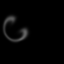
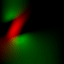
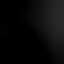


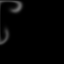
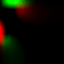
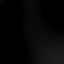


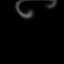
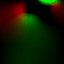
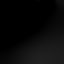


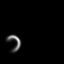
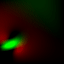
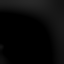


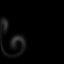
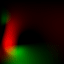
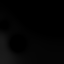

In [17]:
for i in range(5):
  toGif(datasets[i], 40)


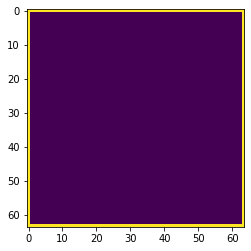

In [18]:
#@title Border Channel  { vertical-output: true}
def getBorder(size):
  b = np.ones((size,size))
  b = np.expand_dims(b,0)
  b = np.expand_dims(b,3)
  b[0,1:-1,1:-1,0] = 0
  b = tf.convert_to_tensor(b)
  b = tf.cast(b, tf.float32)
  return b

border_emb = getBorder(64)

plt.imshow(border_emb[0,:,:,0])
plt.show()

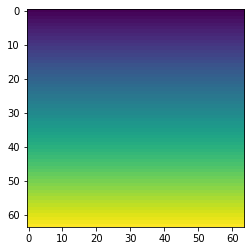

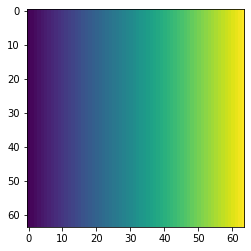

In [19]:
#@title Position Absolute Encoding  { vertical-output: true}
def getPositionEmb2(size):
  l = np.linspace(0, 1, num=size)
  pe_x = np.repeat(l, size, 0)
  pe_x = np.reshape(pe_x, (size, size))
  pe_y = pe_x.T

  pe = np.zeros((1,size,size,2))
  pe[0,:,:,0] = pe_x
  pe[0,:,:,1] = pe_y

  pe = tf.convert_to_tensor(pe)
  pe = tf.cast(pe, tf.float32)

  return tf.convert_to_tensor(pe)

pos_emb = getPositionEmb2(64)

plt.imshow(pos_emb[0,:,:,0])
plt.show()
plt.imshow(pos_emb[0,:,:,1])
plt.show()

In [20]:
alpha = 0.01
lr = 2e-03
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000], [lr, lr*0.05])
optimizer = tf.keras.optimizers.Adam(lr_sched)
loss_object = tf.keras.losses.MeanSquaredError()

In [21]:
#@title + Gauss and finite difference kernels { vertical-output: true}
class NNA(tf.keras.Model):

    def __init__(self, n_channels, n_embedding_channels):
        super().__init__()
        self.channel_n = n_channels
        self.n_embedding_channels = n_embedding_channels
        self.alpha = alpha

        self.dmodel = tf.keras.Sequential([
            tf.keras.layers.Conv2D(128, 1, activation=tf.nn.relu, use_bias = True, padding='same'),
            tf.keras.layers.Conv2D(self.channel_n, 1, padding='same',  activation=None, kernel_initializer=tf.zeros_initializer)
        ])
        z = tf.zeros([1, 3, 3, n_channels], dtype=tf.float32)
        embd = tf.zeros([1, 3, 3, self.n_embedding_channels], dtype=tf.float32)

        cellID = tf.constant([[0., 0., 0.], [0., 1., 0.], [0., 0., 0.]], dtype=tf.float32)
        sobelX = tf.constant([[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]], dtype=tf.float32)
        sobelY = tf.constant([[-1., -2., -1.], [0., 0., 0.], [1., 2., 1.]], dtype=tf.float32)
        gauss = tf.math.scalar_mul(1.0/16.0, tf.constant([[1, 2, 1], [2, 4, 2], [1, 2, 1]],  dtype=tf.float32))
        diffX = tf.constant([[0, 0, 0], [1, 0, -1], [0, 0, 0]], dtype=tf.float32)
        diffY = tf.constant([[0, 1, 0], [0, 0, 0], [0, -1, 0]], dtype=tf.float32)

        kernel = tf.stack([cellID, sobelX, sobelY, diffX, diffY], -1)[:, :, None, :]
        total_channels = self.channel_n + self.n_embedding_channels
        self.kernel = tf.repeat(kernel, total_channels, 2)
        self(z, embd)

    def perceive(self, x):
        y = tf.nn.depthwise_conv2d(x, self.kernel, [1, 1, 1, 1], 'SAME')
        return y

    def call(self, x, embeddings, steps = 1):

        x_complete = np.concatenate((x, embeddings) , axis = -1)

        y = self.perceive(x_complete)

        dx = self.dmodel(y) * steps

        update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= 0.5

        x += dx * tf.cast(update_mask, tf.float32)

        return x

model = NNA(9, 3)
model.summary()

Model: "nna_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (1, 3, 3, 9)              8969      
                                                                 
Total params: 8,969
Trainable params: 8,969
Non-trainable params: 0
_________________________________________________________________


Model: "nna_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (1, 3, 3, 7)              7431      
                                                                 
Total params: 7,431
Trainable params: 7,431
Non-trainable params: 0
_________________________________________________________________


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 0 , Loss cum 121.75518035888672



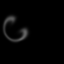
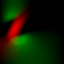
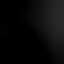
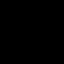
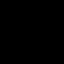

  8%|▊         | 30/400 [00:41<12:07,  1.97s/it]

Epoch 30 , Loss cum 1813.9891357421875



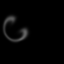
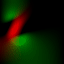
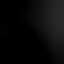
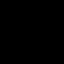
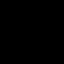

 15%|█▌        | 60/400 [01:25<13:37,  2.40s/it]

Epoch 60 , Loss cum 1607.3853759765625



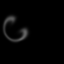
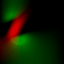
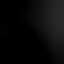
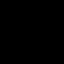
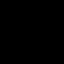

 22%|██▎       | 90/400 [01:50<04:33,  1.13it/s]

Epoch 90 , Loss cum 1107.5533447265625



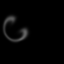
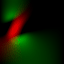
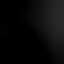
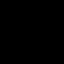
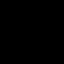

 30%|███       | 120/400 [02:17<03:15,  1.43it/s]

Epoch 120 , Loss cum 1392.225341796875



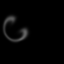
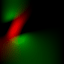
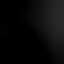
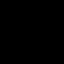
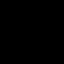

 38%|███▊      | 150/400 [02:43<01:17,  3.24it/s]

Epoch 150 , Loss cum 881.1378784179688



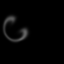
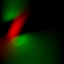
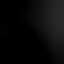
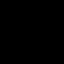
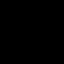

 45%|████▌     | 180/400 [03:07<02:03,  1.78it/s]

Epoch 180 , Loss cum 1167.7923583984375



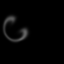
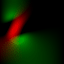
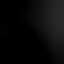
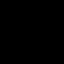
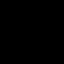

 52%|█████▎    | 210/400 [03:36<02:10,  1.46it/s]

Epoch 210 , Loss cum 1363.3243408203125



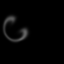
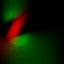
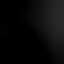
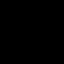
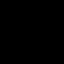

 60%|██████    | 240/400 [03:58<01:22,  1.94it/s]

Epoch 240 , Loss cum 938.8363037109375



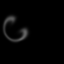
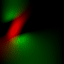
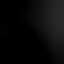
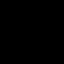
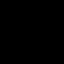

 68%|██████▊   | 270/400 [04:22<01:43,  1.25it/s]

Epoch 270 , Loss cum 859.8995971679688



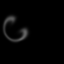
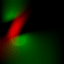
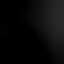
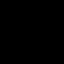
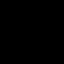

 75%|███████▌  | 300/400 [04:49<01:31,  1.09it/s]

Epoch 300 , Loss cum 767.6796875



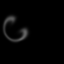
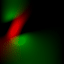
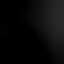
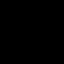
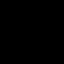

 82%|████████▎ | 330/400 [05:08<00:39,  1.78it/s]

Epoch 330 , Loss cum 751.2469482421875



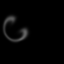
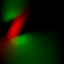
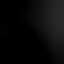
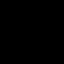
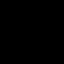

 90%|█████████ | 360/400 [05:33<00:37,  1.06it/s]

Epoch 360 , Loss cum 779.9279174804688



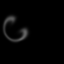
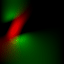
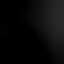
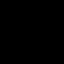
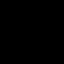

 98%|█████████▊| 390/400 [05:55<00:03,  2.87it/s]

Epoch 390 , Loss cum 762.649658203125



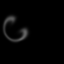
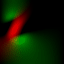
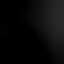
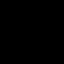
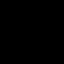

100%|██████████| 400/400 [06:03<00:00,  1.10it/s]


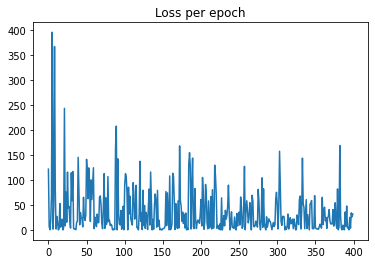

In [22]:

n_channels = 4
n_hidden_channels = 3
extra_steps = 1
alpha = 0.01
model = NNA(n_channels + n_hidden_channels, 3)
model.summary()

embeddins = tf.convert_to_tensor(np.concatenate((pos_emb, border_emb) , axis = -1))

#@title Dye : Loss frame + rand init frame + 10 extra steps + larger kernel { vertical-output: true}
def train_step_frame_at_a_time():
    id = np.random.randint(n_datasets)
    dataset = datasets[id]
    n, _, _, _, _ = np.shape(dataset)
    n = np.random.randint(1,n)
    loss = 0
    x = tf.convert_to_tensor(np.concatenate((dataset[0],np.zeros((1,64,64,n_hidden_channels))) , axis = -1))
    with tf.GradientTape() as g:        
        for i in tf.range(n):
          x = model(x, embeddins, steps = extra_steps)
          loss += loss_object(dataset[i], rgba_m(x)) * 100
    gradients = g.gradient(loss, model.weights)
    gradients = [g / (tf.norm(g) + 1e-8) for g in gradients]
    optimizer.apply_gradients(zip(gradients, model.weights))
    return x, loss


init = x = tf.convert_to_tensor(
    np.concatenate((datasets[0][0],np.zeros((1,64,64,n_hidden_channels))) , axis = -1))
    
EPOCHS = 400
losses = []
loss_cum = 0
for epoch in tqdm(range(EPOCHS)):
    x, loss = train_step_frame_at_a_time()
    loss_cum += loss
    losses.append(loss)
    if epoch % 30 == 0:
      print(f'Epoch {epoch} , Loss cum {loss_cum}')
      loss_cum = 0
      _ = modelToGif(model, init, embeddins, 200, extra_steps, channels=3)

plt.plot(losses)
plt.title("Loss per epoch")
plt.show()


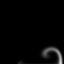
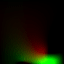
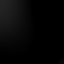
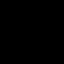
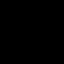


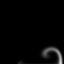
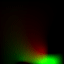
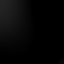


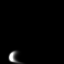
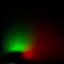
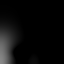
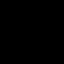
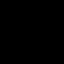


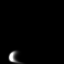
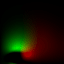
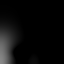


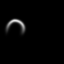
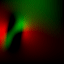
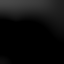
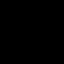
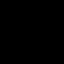


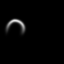
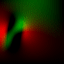
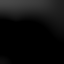


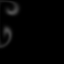
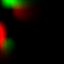
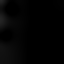
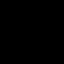
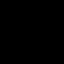


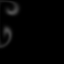
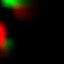
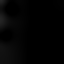


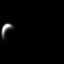
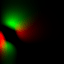
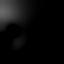
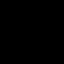
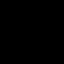


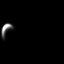
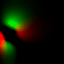
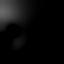

In [23]:

for i in range(10,15):
  init = tf.convert_to_tensor(np.concatenate((datasets[i][0], np.zeros((1,64,64,n_hidden_channels))) , axis = -1))
  _ = modelToGif(model, init ,embeddins, len(datasets[i]) , 1, channels=3)
  toGif(datasets[i], 40)
